In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import signal

In [2]:


with open(r'C:\Users\lhauptmann\Code\WristPPG2\stream\live_data.pkl', 'rb') as f:
    data = pickle.load(f)
    ppg_data = data['ppg_data']
    ppg_timestamps = data['ppg_timestamps']
    imu_data = data['imu_data']
    imu_timestamp = data['imu_timestamp']


def get_correlation_lag(x,y):
    correlation = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(x.size, y.size, mode="full")
    lag = lags[np.argmax(correlation)]
    return lag

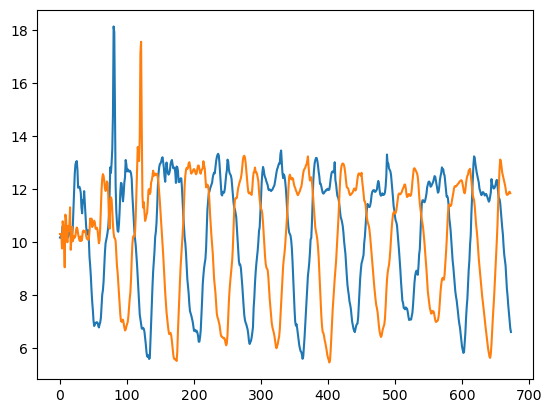

In [3]:
ppg_acc = ppg_data[:,-3:]
imu_acc = imu_data[:,:3]

ppg_mag = np.linalg.norm(ppg_acc, axis=1)
imu_mag = np.linalg.norm(imu_acc, axis=1)

plt.plot(ppg_mag)
plt.plot(imu_mag)

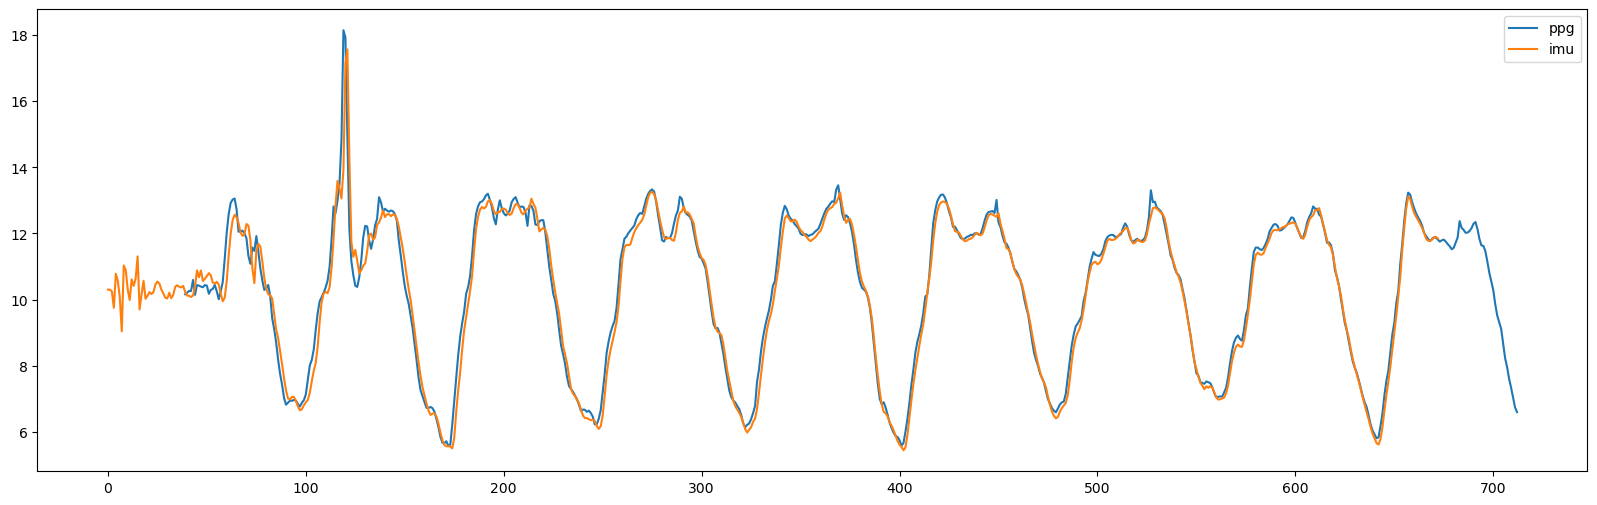

In [4]:
lag_prior = -40
lag = get_correlation_lag(ppg_mag, imu_mag)
lag = int(0.2*lag + 0.8*lag_prior)

plt.figure(figsize=(20, 6))

plt.plot(np.arange(len(ppg_mag)) - lag ,ppg_mag, label='ppg')
plt.plot(np.arange(len(imu_mag)) ,imu_mag, label='imu')
plt.legend()

In [5]:
ppg_data.shape

(674, 19)

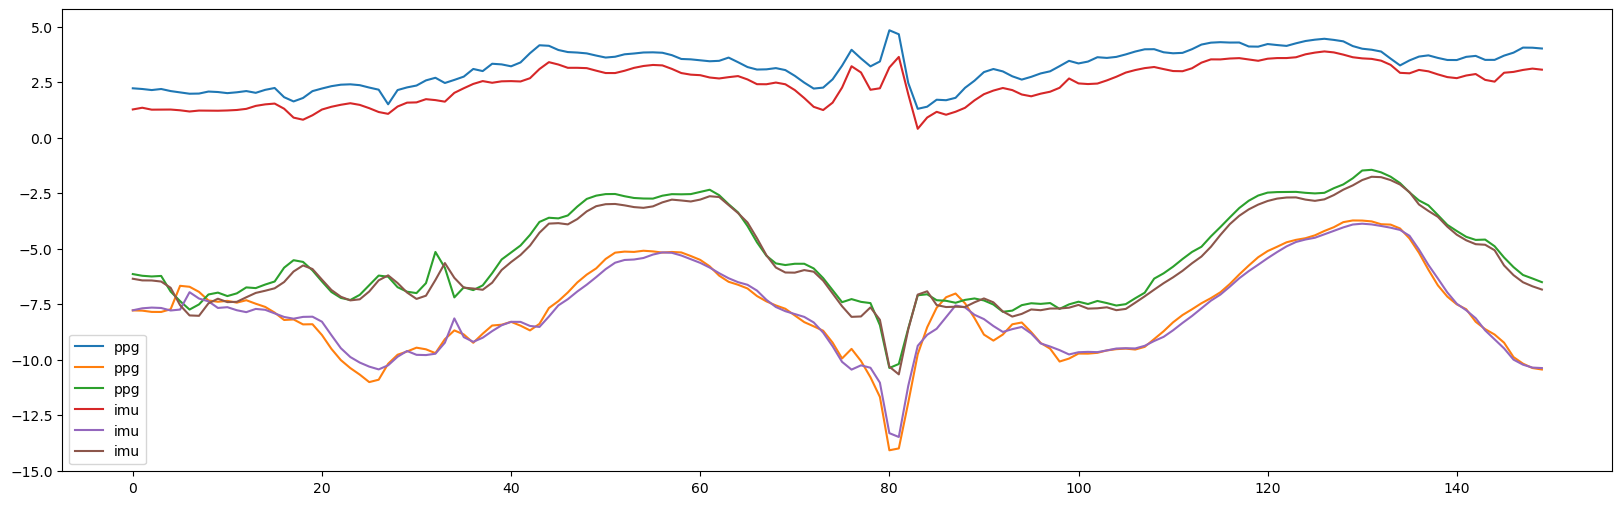

In [6]:
window_size = 150
lag = -40
latest_window_ppg = ppg_data[:window_size]
latest_window_imu = imu_data[-lag:-lag+window_size]

plt.figure(figsize=(20, 6))
plt.plot(latest_window_ppg[:,-3:], label='ppg')
plt.plot(latest_window_imu[:,:3], label='imu')
plt.legend()

In [32]:
sample = {
    "ppg": torch.Tensor(latest_window_ppg[:,:-3]).T.unsqueeze(0),
    "accel": torch.Tensor(latest_window_imu[:,:3]).T.unsqueeze(0),
    "gyro": torch.Tensor(latest_window_imu[:,3:6]).T.unsqueeze(0),
    "ppg_accel": torch.Tensor(latest_window_ppg[:,-3:]).T.unsqueeze(0),
}

for key in sample.keys():
    sample[key] = (sample[key] - sample[key].mean(axis=1)) / sample[key].std(axis=1)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn
from pathlib import Path
import yaml
import sys
import glob
import os
sys.path.append(r"C:\Users\lhauptmann\Code\GestureDetection")


    
LETTER_GESTURES = {
"a": "Swipe Forward",
"b": "Swipe Backward",
"c": "Swipe Left",
"d": "Swipe Right",
"p": "Fast Pinch",
"prr": "Rotate Right",
"prl": "Rotate Left",
"pbd": "Back to Default",
"pc": "Pinch Hold",
"po": "Pinch Open",
"sp": "Side Tap",
"o": "Nothing",
"s": "Knock"
}
LABEL_TO_LETTER = {
    0: "a",
    1: "b",
    2: "c",
    3: "d",
    4: "p",
    5: "po",
    6: "sp",
    7: "o",
    8: "prr",
    9: "prl",
    10: "pbd",
    8: "pc",
    12: "s"
}

LABEL_TO_GESTURE = {key: LETTER_GESTURES[val] for key, val in LABEL_TO_LETTER.items()}

GESTURE_TO_LABEL = {
    "a":0,
    "b":1,
    "c":2,
    "d":3,
    "p":4,
    "prr":7,
    "prl":7,
    "pbd":7,
    "pc":8,
    "po":5,
    "sp":6,
    "o":7,
    "s":7
}

model_path = r"C:\Users\lhauptmann\Code\GestureDetection\experiments\2024-12-03_180833"

In [16]:
glob.glob(os.path.join(model_path, "checkpoint_*.pt"))

['C:\\Users\\lhauptmann\\Code\\GestureDetection\\experiments\\2024-12-03_180833\\checkpoint__93600.pt']

In [ ]:
model_path

In [17]:
load_config=Path(os.path.join(model_path,"config.yml"))
config = yaml.load(load_config.read_text(), Loader=yaml.Loader)
#del(config.model.nsensors["accel"])
#del(config.model.nhidden_units["accel"])
#del(config.model.nsensors["gyro"])
#del(config.model.nhidden_units["gyro"])
#del(config.model.nsensors["ppg"])
#del(config.model.nhidden_units["ppg"])
config.model.nsensors["ppg"] = 16
device = "cpu"
config.device = device
config.data_config.max_shift = 0



model = config.model.setup(prediction_heads={"gesture":9}).to(device)
weights_path = glob.glob(os.path.join(model_path , "best_model__*.pt"))[0]
weights_path = glob.glob(os.path.join(model_path , "checkpoint_*.pt"))[0]
load_state_dict = torch.load(weights_path, map_location=device)["model_state_dict"]
print(f"Loading model from {weights_path}")

# remove all weights that correspond to pred_head
#load_state_dict = {k: v for k, v in load_state_dict.items() if not k.startswith("pred_heads")}
model.load_state_dict(load_state_dict, strict=False)
model.eval()

Loading model from C:\Users\lhauptmann\Code\GestureDetection\experiments\2024-12-03_180833\checkpoint__93600.pt


C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_11920\3838235201.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_state_dict = torch.load(weights_path, map_locatio

BaysianVGGNetmax(
  (nets): ModuleDict(
    (accel): GenericVGGNetwork(
      (blocks): ModuleList(
        (0): Sequential(
          (0): Conv1d(3, 32, kernel_size=(7,), stride=(1,), padding=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
        (1): Sequential(
          (0): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
          (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (dropout): Dropout1d(p=0.5, inplace=False)
        )
        (2): Sequential(
          (0): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(1,))
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negativ

In [52]:
sample["accel"].shape

torch.Size([1, 3, 150])

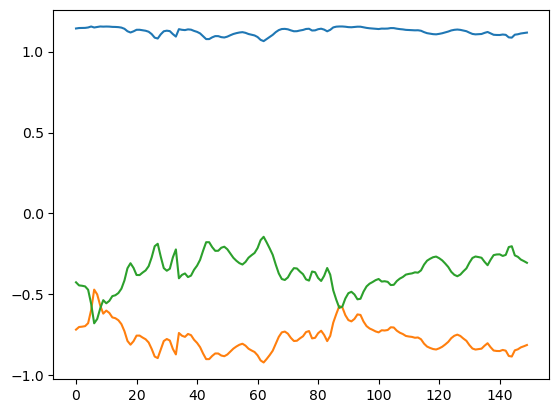

In [50]:
plt.plot(sample["accel"][0].T)

In [ ]:
sample

In [34]:
output,_,_,xf = model(sample)

<BarContainer object of 9 artists>

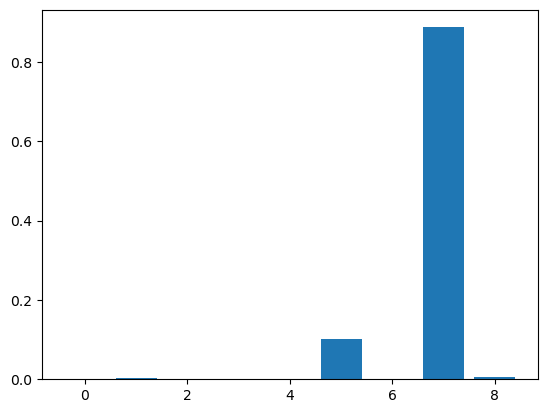

In [47]:
probs = torch.nn.functional.softmax(output, dim=1)
plt.bar(np.arange(9), probs.squeeze().detach().numpy())

In [43]:
torch.exp(output)

tensor([[3.7641e-01, 1.6292e+00, 2.4869e-01, 2.0868e-01, 2.8744e-01, 7.8858e+01,
         1.8648e-01, 6.8636e+02, 5.2248e+00]], grad_fn=<ExpBackward0>)